# Visualization of Utah COVID-19 Cases for 2020

Inspriation for these visualizations came from [Matt Harrison's](https://www.linkedin.com/in/panela/) daily COVID-19 plots that he began publishing on LinkedIn during the spring of 2020.

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

Let me see all columns

In [3]:
pd.options.display.max_columns = 999

This is required to eliminate a pandas deprecation warning related to implicit datetime conversions.

In [4]:
pd.plotting.register_matplotlib_converters()

Raw data location on Github or local storage

In [5]:
# Local disk
# url = r"C:\src\covid-tracking-data\data\states_daily_4pm_et.csv"

# Forked repository with repaired data
url = ('https://github.com/jedludlow/covid-tracking-data/'
       'raw/repair-ut-data/data/states_daily_4pm_et.csv')

# Main repository of tracking data
# url = ('https://github.com/COVID19Tracking/covid-tracking-data/'
#        'raw/master/data/states_daily_4pm_et.csv')

In [6]:
df = pd.read_csv(url, parse_dates=['date', 'dateChecked'])

In [7]:
df[df['state'] == 'UT'].head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,dataQualityGrade,lastUpdateEt,hash,dateChecked,death,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
48,2020-05-28,UT,8921.0,194586.0,NaN,169.0,734.0,NaN,231.0,NaN,98.0,5623.0,B,5/28/2020 10:04,d5814481b1d5eedb1e2494bba14567ef694b7863,2020-05-28 20:00:00+00:00,106.0,734.0,203507,203507,203507,49,1.0,18.0,2666.0,215.0,2881.0
104,2020-05-27,UT,8706.0,191920.0,NaN,127.0,716.0,NaN,223.0,NaN,94.0,5499.0,B,5/27/2020 11:04,03746f86c830503f7561f8a9bff6cecd939ec0e5,2020-05-27 20:00:00+00:00,105.0,716.0,200626,200626,200626,49,4.0,20.0,1948.0,86.0,2034.0
160,2020-05-26,UT,8620.0,189972.0,NaN,134.0,696.0,NaN,217.0,NaN,89.0,5346.0,B,5/26/2020 10:19,0adcf0c6d702b42e4da80c1ac92711915ee1c5ad,2020-05-26 20:00:00+00:00,101.0,696.0,198592,198592,198592,49,3.0,4.0,2025.0,99.0,2124.0
216,2020-05-25,UT,8521.0,187947.0,NaN,131.0,692.0,NaN,215.0,NaN,88.0,5218.0,B,5/25/2020 10:15,8349bfd5604977dbad7c0ecc346b41c90ef261b4,2020-05-25 20:00:00+00:00,98.0,692.0,196468,196468,196468,49,1.0,4.0,1906.0,129.0,2035.0
272,2020-05-24,UT,8392.0,186041.0,NaN,128.0,688.0,NaN,215.0,NaN,88.0,5081.0,B,5/24/2020 10:39,c0789037031d9e5a1837ae58555e59e66c84bf52,2020-05-24 20:00:00+00:00,97.0,688.0,194433,194433,194433,49,0.0,-365.0,3522.0,132.0,3654.0


In [8]:
days = mdates.DayLocator()
months = mdates.MonthLocator()
formatter = mdates.ConciseDateFormatter(days)

In [9]:
sns.set(context='talk', palette='deep', color_codes=True, style='darkgrid')

## Matt Harrison's Original Plot

With some added `seaborn` styling....

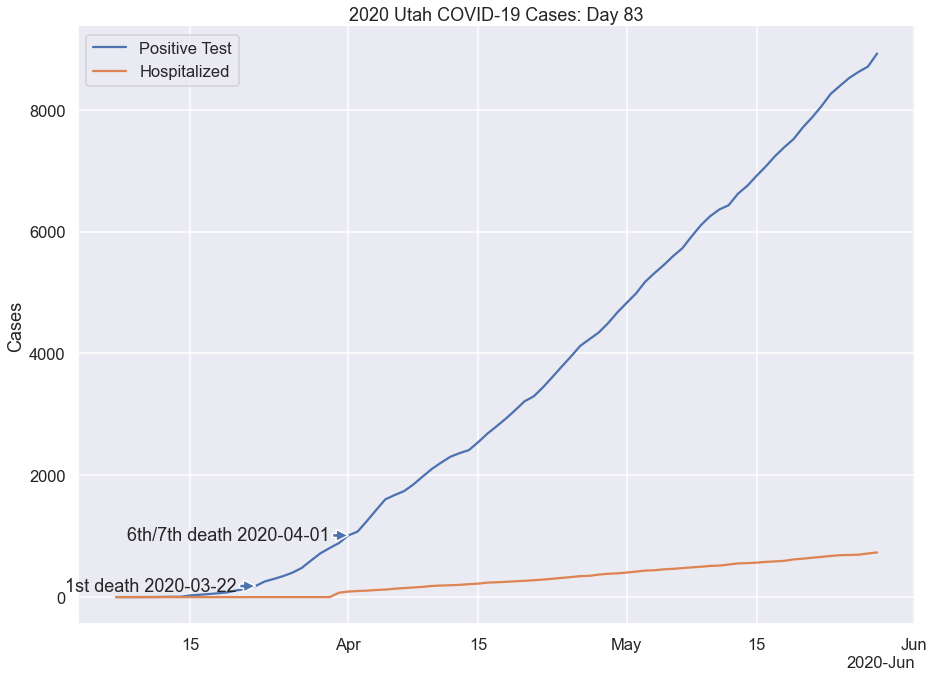

In [10]:
with sns.plotting_context('talk'):
    data = (df
            [df.state == 'UT']
            .set_index('date')
            [['positive', 'hospitalized', 'death']]
            .fillna(0)
           )
    fig, ax = plt.subplots(figsize=(15, 11))
    ax.plot(data.positive, label='Positive Test')
    ax.plot(data.hospitalized, label='Hospitalized')
    ax.set_ylabel('Cases')
    ax.set_title(f'2020 Utah COVID-19 Cases: Day {data.shape[0]}')

#     ax.xaxis.set_major_locator(days)
    ax.xaxis.set_major_formatter(formatter)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)
    
    deaths = [
        ('1st', pd.Timestamp('2020-03-22')),
#         ('2nd', pd.Timestamp('2020-03-27')),
#         ('3rd/4th', pd.Timestamp('2020-03-29')),
#         ('5th', pd.Timestamp('2020-03-31')),
        ('6th/7th', pd.Timestamp('2020-04-01'))
    ]
    
    for num, date in deaths:
        val = data.loc[date, 'positive']
        ax.annotate(f'{num} death {date.strftime("%Y-%m-%d")}',
                    xy=(date, val),
                    xytext=(date - pd.DateOffset(days=2), val),
                    arrowprops={},
                    horizontalalignment='right',
                    verticalalignment='center'
                   )
    sns.despine()
    ax.legend(loc='upper left')

## Break Out Subplots

How does it look if we break everything out into subplots instead?

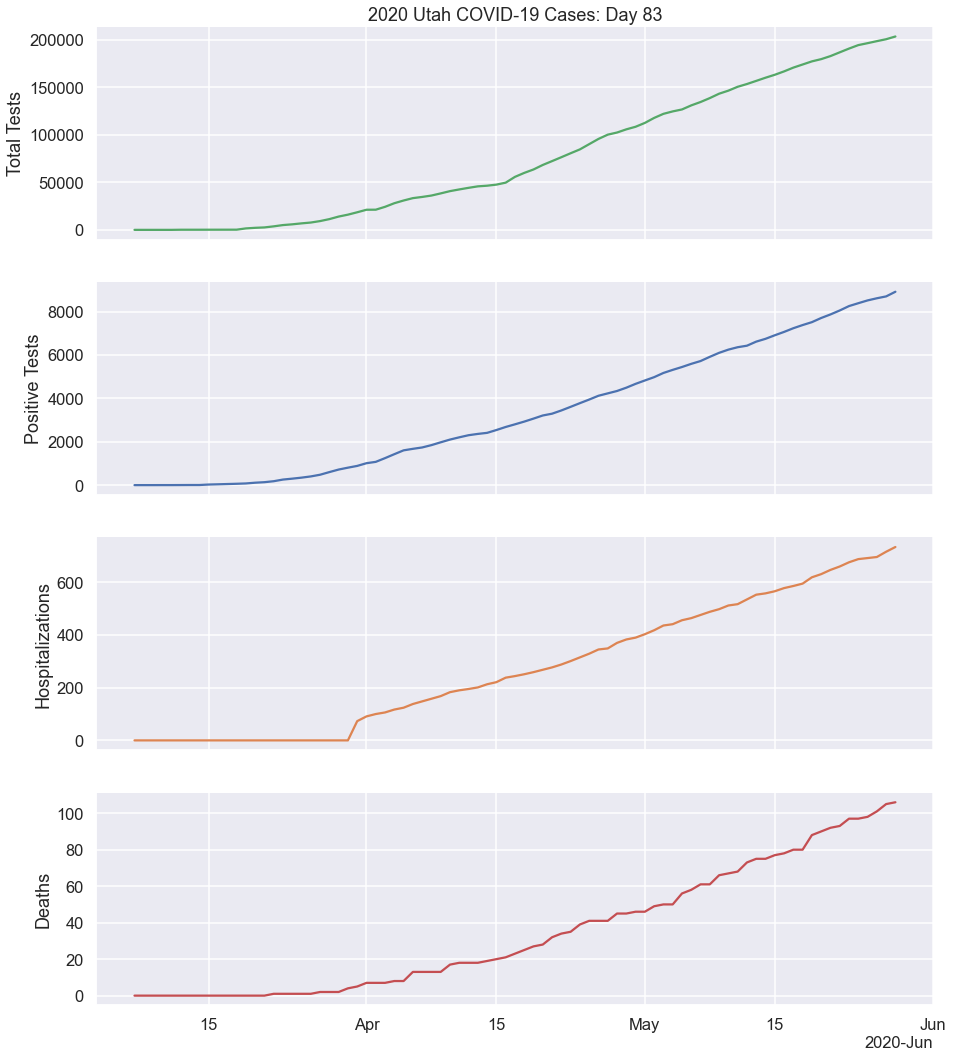

In [11]:
with sns.plotting_context('talk'):
    data = (df
            [df.state == 'UT']
            .set_index('date')
            [['positive', 'hospitalized', 'death', 'totalTestResults']]
            .fillna(0)
           )
    fig, ax = plt.subplots(4, 1, figsize=(15, 18), sharex=True)
 
    ax[0].plot(data.totalTestResults, color='C2', label='Total Tests')
    ax[0].set_ylabel('Total Tests')
    ax[0].set_title(f'2020 Utah COVID-19 Cases: Day {data.shape[0]}')
    
    ax[1].plot(data.positive, color='C0', label='Positive Test')
    ax[1].set_ylabel('Positive Tests')
    
    ax[2].plot(data.hospitalized, color='C1', label='Hospitalized')
    ax[2].set_ylabel('Hospitalizations')
    
    ax[3].plot(data.death, color='C3', label='Deaths')
    ax[3].set_ylabel('Deaths')

#     ax[0].xaxis.set_major_locator(days)
    ax[0].xaxis.set_major_formatter(formatter)
    plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=0)
    
    sns.despine()

## Multiple Y Axes on Single Plot

The subplots indicate similar curve shapes. Let's express them on a common plot with multiple y axes. Additionally, let's ignore the missing hospitalization data rather than fill it with zeros.

Inspiration for the multiple axes technique comes from the [Multiple Yaxis Wtih Spines](https://matplotlib.org/3.1.1/gallery/ticks_and_spines/multiple_yaxis_with_spines.html) example on the matplotlib site.

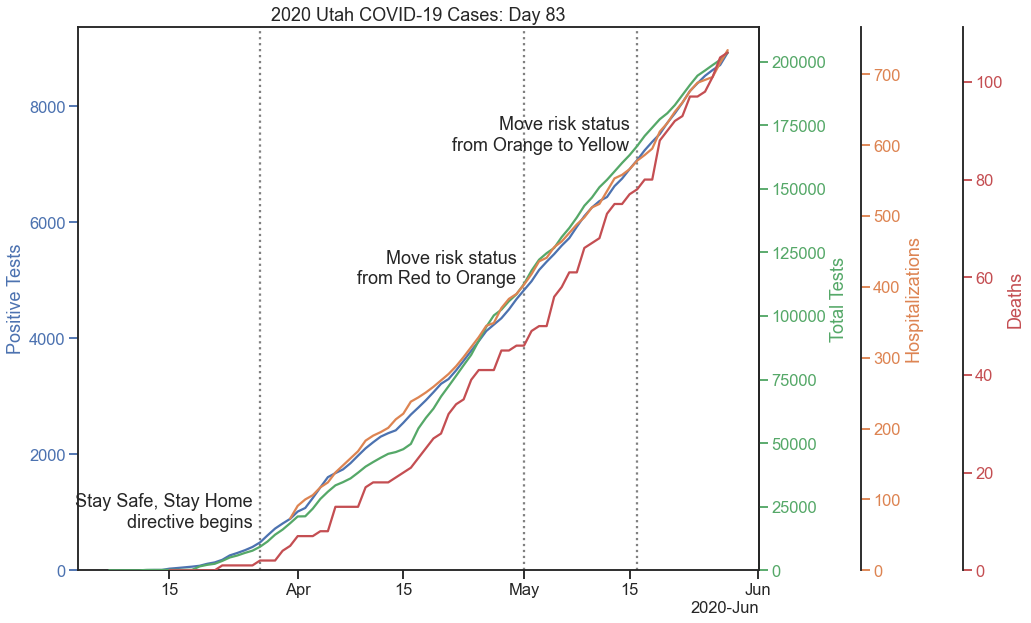

In [12]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

with sns.axes_style('ticks'):
    data = (df
            [df.state == 'UT']
            .set_index('date')
            [['positive', 'hospitalized', 'death', 'totalTestResults']]
#             .fillna(0)
           )
    fig, ax_0 = plt.subplots(1, 1, figsize=(18, 10), sharex=True)
    fig.subplots_adjust(right=0.65)

    ax_1 = ax_0.twinx()
    ax_2 = ax_0.twinx()
    ax_3 = ax_0.twinx()

    ax_2.spines['right'].set_position(('axes', 1.15))
    ax_3.spines['right'].set_position(('axes', 1.3))

    make_patch_spines_invisible(ax_1)
    make_patch_spines_invisible(ax_2)
    make_patch_spines_invisible(ax_3)

    ax_1.spines['right'].set_visible(True)
    ax_2.spines['right'].set_visible(True)
    ax_3.spines['right'].set_visible(True)

    tick_kws = dict()

    line_0, = ax_0.plot(data.positive, color='C0', label='Positive Test')
    ax_0.set_ylabel('Positive Tests')
    ax_0.set_title(f'2020 Utah COVID-19 Cases: Day {data.shape[0]}')
    ax_0.yaxis.label.set_color(line_0.get_color())
    ax_0.set_ylim(bottom=0.0)
    ax_0.tick_params(axis='y', colors=line_0.get_color(), **tick_kws)
    
    # Add public health directive markers
    ax_0.axvline('2020-03-27', color='gray', ls=':', zorder=-1)
    ax_0.annotate("Stay Safe, Stay Home\ndirective begins",
                    xy=('2020-03-26', 1000),
                    horizontalalignment='right',
                    verticalalignment='center'
                   )
    
    ax_0.axvline('2020-05-01', color='gray', ls=':', zorder=-1)
    ax_0.annotate("Move risk status\nfrom Red to Orange",
                    xy=('2020-04-30', 5200),
                    horizontalalignment='right',
                    verticalalignment='center'
                   )
    
    ax_0.axvline('2020-05-16', color='gray', ls=':', zorder=-1)
    ax_0.annotate("Move risk status\nfrom Orange to Yellow",
                    xy=('2020-05-15', 7500),
                    horizontalalignment='right',
                    verticalalignment='center'
                   )

    line_1, = ax_1.plot(data.totalTestResults, color='C2', label='Total Tests')
    ax_1.set_ylabel('Total Tests')
    ax_1.yaxis.label.set_color(line_1.get_color())
    ax_1.set_ylim(bottom=0.0)
    ax_1.tick_params(axis='y', colors=line_1.get_color(), **tick_kws)

    line_2, = ax_2.plot(data.hospitalized, color='C1', label='Hospitalized')
    ax_2.set_ylabel('Hospitalizations')
    ax_2.yaxis.label.set_color(line_2.get_color())
    ax_2.set_ylim(bottom=0.0)
    ax_2.tick_params(axis='y', colors=line_2.get_color(), **tick_kws)

    line_3, = ax_3.plot(data.death, color='C3', label='Deaths')
    ax_3.set_ylabel('Deaths')
    ax_3.yaxis.label.set_color(line_3.get_color())
    ax_3.set_ylim(bottom=0.0)
    ax_3.tick_params(axis='y', colors=line_3.get_color(), **tick_kws)

#     ax_0.xaxis.set_major_locator(days)
    ax_0.xaxis.set_major_formatter(formatter)
    plt.setp(ax_0.xaxis.get_majorticklabels(), rotation=0)

fig.savefig('covid_multiple_y_axes.png', dpi=300, bbox_inches='tight')
#     sns.despine()

## Multiple Y Axes on Single Plot, Log Scaling on Y

Shameless copy-paste of the plot above to experiment with log y scaling.

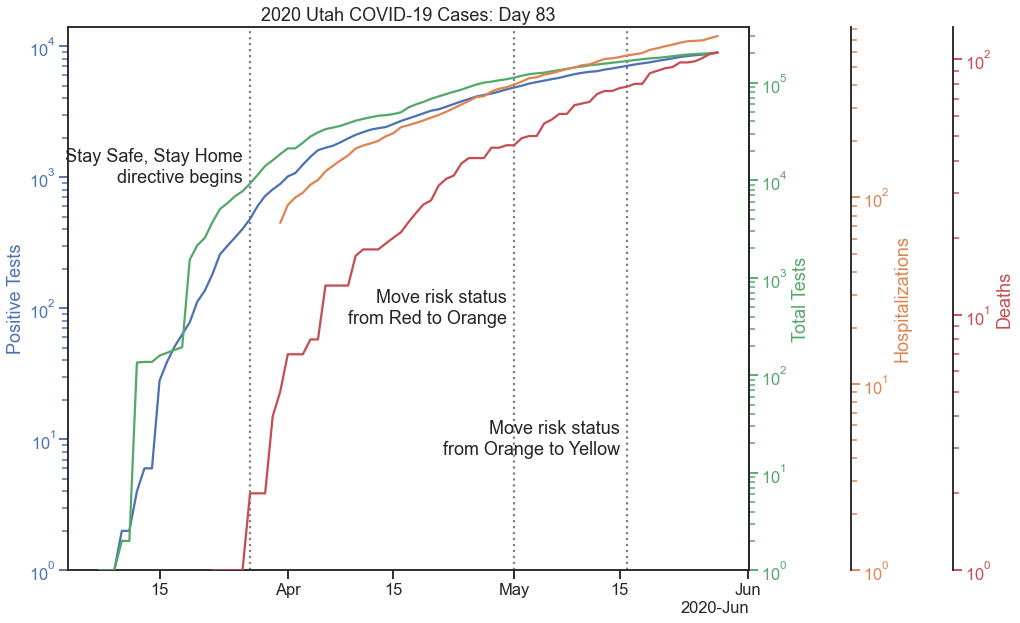

In [13]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

with sns.axes_style('ticks'):
    data = (df
            [df.state == 'UT']
            .set_index('date')
            [['positive', 'hospitalized', 'death', 'totalTestResults']]
#             .fillna(0)
           )
    fig, ax_0 = plt.subplots(1, 1, figsize=(18, 10), sharex=True)
    fig.subplots_adjust(right=0.65)

    ax_1 = ax_0.twinx()
    ax_2 = ax_0.twinx()
    ax_3 = ax_0.twinx()

    ax_2.spines['right'].set_position(('axes', 1.15))
    ax_3.spines['right'].set_position(('axes', 1.3))

    make_patch_spines_invisible(ax_1)
    make_patch_spines_invisible(ax_2)
    make_patch_spines_invisible(ax_3)

    ax_1.spines['right'].set_visible(True)
    ax_2.spines['right'].set_visible(True)
    ax_3.spines['right'].set_visible(True)

    tick_kws = dict()

    line_0, = ax_0.semilogy(data.positive, color='C0', label='Positive Test')
    ax_0.set_ylabel('Positive Tests')
    ax_0.set_title(f'2020 Utah COVID-19 Cases: Day {data.shape[0]}')
    ax_0.yaxis.label.set_color(line_0.get_color())
    ax_0.set_ylim(bottom=1.0)
    ax_0.tick_params(axis='y', which='both', colors=line_0.get_color(), **tick_kws)
    
    # Add public health directive markers
    ax_0.axvline('2020-03-27', color='gray', ls=':', zorder=-1)
    ax_0.annotate("Stay Safe, Stay Home\ndirective begins",
                    xy=('2020-03-26', 1200),
                    horizontalalignment='right',
                    verticalalignment='center'
                   )
    
    ax_0.axvline('2020-05-01', color='gray', ls=':', zorder=-1)
    ax_0.annotate("Move risk status\nfrom Red to Orange",
                    xy=('2020-04-30', 100),
                    horizontalalignment='right',
                    verticalalignment='center'
                   )
    
    ax_0.axvline('2020-05-16', color='gray', ls=':', zorder=-1)
    ax_0.annotate("Move risk status\nfrom Orange to Yellow",
                    xy=('2020-05-15', 10),
                    horizontalalignment='right',
                    verticalalignment='center'
                   )

    line_1, = ax_1.semilogy(data.totalTestResults, color='C2', label='Total Tests')
    ax_1.set_ylabel('Total Tests')
    ax_1.yaxis.label.set_color(line_1.get_color())
    ax_1.set_ylim(bottom=1.0)
    ax_1.tick_params(axis='y', which='both', colors=line_1.get_color(), **tick_kws)

    line_2, = ax_2.semilogy(data.hospitalized, color='C1', label='Hospitalized')
    ax_2.set_ylabel('Hospitalizations')
    ax_2.yaxis.label.set_color(line_2.get_color())
    ax_2.set_ylim(bottom=1.0)
    ax_2.tick_params(axis='y', which='both', colors=line_2.get_color(), **tick_kws)

    line_3, = ax_3.semilogy(data.death, color='C3', label='Deaths')
    ax_3.set_ylabel('Deaths')
    ax_3.yaxis.label.set_color(line_3.get_color())
    ax_3.set_ylim(bottom=1.0)
    ax_3.tick_params(axis='y', which='both', colors=line_3.get_color(), **tick_kws)

#     ax_0.xaxis.set_major_locator(days)
    ax_0.xaxis.set_major_formatter(formatter)
    plt.setp(ax_0.xaxis.get_majorticklabels(), rotation=0)

fig.savefig('covid_multiple_log_y_axes.png', dpi=300, bbox_inches='tight')
#     sns.despine()

In [14]:
data.head()

,positive,hospitalized,death,totalTestResults
date,,,,
2020-05-28,8921.0,734.0,106.0,203507
2020-05-27,8706.0,716.0,105.0,200626
2020-05-26,8620.0,696.0,101.0,198592
2020-05-25,8521.0,692.0,98.0,196468
2020-05-24,8392.0,688.0,97.0,194433
